In [17]:
import numpy as np
import pandas as pd
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score, log_loss, accuracy_score


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

import matplotlib.pyplot as plt

In [18]:
# importing the full dataframe from Assignment 5
merged_df = pd.read_csv("merged_final.csv")

# adding stock value as a column
merged_df['value'] = merged_df['PRC'] * merged_df['VOL']

In [19]:
rf_month = pd.read_sas("ff_factors_monthly.sas7bdat")

rf_month['dateff'] = pd.to_datetime(rf_month['dateff'])
#rf_month = rf_month[rf_month['dateff']]
rf_month = rf_month[rf_month['dateff'].dt.year >= 1980]
rf_month = rf_month[['dateff', 'RF']]

def month_format(month):
    if len(month) == 1:
        month = str(0) + month
        return month
    else:
        return month

rf_month['year'] = rf_month['dateff'].apply(lambda x: str(x.year))
rf_month['month'] = rf_month['dateff'].apply(lambda x: str(x.month))
rf_month['month'] = rf_month['month'].apply(month_format)
rf_month['yyyymm'] = rf_month['year'] + rf_month['month']
rf_month['yyyymm'] = rf_month['yyyymm'].apply(lambda x: float(x))

rf_month = rf_month[['RF', 'yyyymm']]

In [20]:
# adding risk free rate to merged_df
merged_df = merged_df.merge(rf_month, on = ['yyyymm'])

# setting index to permno-yyyymm
merged_df['permno-yyyymm'] = merged_df['permno'].apply(lambda x: str(x)) + merged_df['yyyymm'].apply(lambda x: str(x)[:-2])
merged_df['permno-yyyymm'] = merged_df['permno-yyyymm'].apply(lambda x: int(x))
merged_df.set_index(merged_df['permno-yyyymm'], inplace = True)

# dropping the permno-yyyymm column
merged_df.drop(['permno-yyyymm'], axis= 1, inplace= True)
#merged_df.drop(['Unnamed: 0'], axis= 1, inplace= True)

In [21]:
# validation function
def validate_model(model_type, param_grid, x_train, y_train, x_validate, y_validate):
    # Special case for LinearRegression because it doesn't have hyperparameters to tune
    if model_type == LinearRegression:
        model = LinearRegression()
        model.fit(x_train, y_train)
        pred = model.predict(x_validate)
        r2 = r2_score(y_validate, pred)
        
        return r2
    else: # The other cases
        
        # Establishses the ParameterGrid
        model_param_grid = ParameterGrid(param_grid)
        
        # Initialize values
        best_MAE = 0
        best_r2 = 1
        best_config = None
        # Iterate through the parameter grid, fit models to the hyperparameters
        # and check for MAE and R2 values
        
        # each param_config in that validation function would represent 1 combination of the possible parameters.
        # for example in Lab 6, when I'm validating for the elastic net regression, I have 
        # 2 possible hyperparameters: alpha and l1_ratio. 
        #alpha can take on values 0.0001, 0.0005, etc, and l1_ratio can take on values 0, 1, 0.01. 
        #So each param_config in the for loop in validate_model would go over 1 possible 
        #combination of the hyperparameter and keep the one that gives us the best MAE/R2
        for param_config in model_param_grid:
            curr_config_MAEs = []
            model = model_type(**param_config)
            model.fit(x_train, y_train)
            pred = model.predict(x_validate)
            MAE = mean_squared_error(y_validate,pred)
            r2 = r2_score(y_validate, pred)
            curr_config_MAEs.append(MAE)
            if best_MAE == 0 or (MAE < best_MAE):
                best_MAE = MAE
                best_config = param_config
            if best_r2 == 1 or (r2 > best_r2):
                best_r2 = r2
        return best_config, best_MAE, best_r2

In [22]:
# Predictions
def pred(model_type, x_train, y_train, x_test, y_test):
    # Fit model and predict 
    model = model_type.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    # Format prediction as DataFrame
    pred_df = pd.DataFrame(pred, columns = ['RET_pred'])
    pred_df.set_index(x_test.index, inplace = True)
    
    r2 = r2_score(y_test, pred)
    return pred_df, r2

In [23]:
# extracts year from index
def year_extract(index):
    return int(str(index)[5:])
# vectorizes the function
vyear_extract = np.vectorize(year_extract)

In [24]:
# Function to build the portfolio and calculate different performance metrics
def portfolio_build(df_pred, model_name, df_realized):
    # Get the year
    df_pred['yyyymm'] = vyear_extract(df_pred.index.values)
    df_pred.sort_values(by = 'yyyymm', inplace = True)
    
    # Initialize list of values
    long_short_lst = []
    value_lst = []
    
    # Iterate over years
    for time in df_pred['yyyymm'].unique():
        # Subset by year
        df_curr = df_pred[df_pred['yyyymm'] == time]
        # Sort the values by returns
        df_curr = df_curr.sort_values(by = ['RET_pred'], ascending = False)
        size = math.floor(df_curr.shape[0]/10)
        # Get the top/bottom performing stocks
        df_top = df_curr.head(size)
        df_bot = df_curr.tail(size)
        # Get the actual returns of the predicted top/bottom performers
        df_top_realized = df_realized.loc[df_top.index]
        df_bot_realized = df_realized.loc[df_bot.index]
        
    
        # Get the mean returns of these top/bottom performers
        mu_top = df_top_realized['RET'].mean()
        mu_bot = df_bot_realized['RET'].mean()
        
     
        # Get the mean returns by shorting the bottom and going long on the top
        long_short = (mu_top - mu_bot)
        
        value = df_top['value'].sum()
        value = value + df_bot['value'].sum()
        
        long_short_lst.append(long_short)
        value_lst.append(value)
    
    # Get the value for the portfolio
    ls_df = pd.DataFrame(long_short_lst, columns = ['ls_ret'], index = df_pred['yyyymm'].unique())
    ls_df['value'] = value_lst
    
    # Calculating cumulative returns
    # First we +1 to the returns 
    # Then we do the cumulative product
    ls_df['cumulative_ret']= ls_df['ls_ret'] + 1
    ls_df['cumulative_ret'] = ls_df['cumulative_ret'].cumprod()
    
    # Get mean/std/sharpe ratio for the portfolio
    ls_df = pd.merge(ls_df, rf_month, left_index = True, right_index = True)
    ls_df['ls_sub_rf'] = ls_df['ls_ret'] - ls_df['RF']
    ls_sub_rf_mean = ls_df['ls_sub_rf'].mean()*12
    ls_sub_rf_std = ls_df['ls_sub_rf'].std()*math.sqrt(12)
    sharpe_ratio = ls_sub_rf_mean/ls_sub_rf_std*math.sqrt(12)
    
    print("The annualized excess return "+ model_name + " long short portfolio is: " + str(ls_sub_rf_mean))
    print("The annualized std dev of returns of " + model_name + " long short portfolio is: " + str(ls_sub_rf_std))
    print("The anualized Sharpe ratio of " + model_name + " long short portfolio is: " + str(sharpe_ratio))
    
    return ls_df, ls_sub_rf_mean, ls_sub_rf_std, sharpe_ratio

In [25]:
# using a 60/20/20 split
train, validate, test = \
                        np.split(merged_df.sample(frac=1, random_state=42), 
                        [int(.6*len(merged_df)), int(.8*len(merged_df))])

factors = list(train.columns[9:41])

x_train = train[factors]
y_train = train['RET']

x_validate = validate[factors]
y_validate = validate['RET']

x_test = test[factors]
y_test = test['RET']

In [26]:
# random sample of 50 to train, 20 to validate. Makes validation step take about 6 hours on my local machine
rand_50_df_train = merged_df.sample(n= 50, random_state= 42)
rand_20_df_vali =  merged_df.sample(n=20, random_state= 1)

x_train = rand_50_df_train[factors]
y_train = rand_50_df_train['RET']

x_validate = rand_20_df_vali[factors]
y_validate = rand_20_df_vali['RET']

In [27]:
# Validation parameter grids. This is what I fed into the vali function 
# and ran it on the computer cluster
Pasting_para_grid_dict = {'base_estimator':[MLPRegressor(hidden_layer_sizes=(32,16,8,4),
                                  learning_rate= 'adaptive',
                                  learning_rate_init= 0.001,
                                  alpha= 0.001,
                                  solver= 'adam',
                                  max_iter= 100)],
                  'n_estimators': np.arange(1, 100, 1),
                  'max_features': np.arange(1, 32, 1),
                  'max_samples': np.arange(0.1, 1.1, 0.1), 
                  'bootstrap': [False],
                  'n_jobs': [-1]}
                  
Bagging_para_grid_dict = {'base_estimator':[MLPRegressor(hidden_layer_sizes=(32,16,8,4),
                                  learning_rate= 'adaptive',
                                  learning_rate_init= 0.001,
                                  alpha= 0.001,
                                  solver= 'adam',
                                  max_iter= 100)],
                  'max_samples': np.arange(0.1, 1.1, 0.1),
                  'n_estimators': np.arange(1, 100, 1),
                  'bootstrap': [True],
                  'max_features': np.arange(1, 32, 1),
                  'n_jobs': [-1]}

RandSub_para_grid_dict = {'base_estimator':[MLPRegressor(hidden_layer_sizes=(32,16,8,4),
                                  learning_rate= 'adaptive',
                                  learning_rate_init= 0.001,
                                  alpha= 0.001,
                                  solver= 'adam',
                                  max_iter= 100)],
                  'n_estimators': np.arange(1, 100, 1),
                  'max_features': np.arange(1, 32, 1),
                  'n_jobs': [-1]}
RandPat_para_grid_dict = {'base_estimator':[MLPRegressor(hidden_layer_sizes=(32,16,8,4),
                                  learning_rate= 'adaptive',
                                  learning_rate_init= 0.001,
                                  alpha= 0.001,
                                  solver= 'adam',
                                  max_iter= 100)],
                  'n_estimators': np.arange(1, 100, 1),
                  'max_features': np.arange(1, 32, 1),
                  'max_samples':np.arange(0.1, 1.1, 0.1),
                  'n_jobs': [-1]}

In [28]:
# This is the sample code for validating the Pasting model
# You would get the hyperparameters from pasting_vali_config
# Caveat: Each model takes a long time
# This part of the code is mannually terminated to save time. Results hence are not optimal

# This would have to be run for the other models as well. 
Pasting_vali_config, Pasting_best_MAE, Pasting_best_r2 = \
    validate_model(BaggingRegressor, Pasting_para_grid_dict, x_train, y_train, x_validate, y_validate)

KeyboardInterrupt: 

In [29]:
# Pasting -> draw random subset of rows w/o replacement
# max_features= total features, max_samples= (from vali), bootstrap = False

pasting_pred_df, pasting_pred_r2 = pred(BaggingRegressor(base_estimator = MLPRegressor(hidden_layer_sizes = (32, 16, 8, 4),
                                                              learning_rate= 'adaptive',
                                                              learning_rate_init= 0.001,
                                                              alpha= 0.001,
                                                              solver= 'adam',
                                                              max_iter= 100),
                                 n_estimators= 3,
                                 max_features= 32,
                                 max_samples= 0.1,
                                 bootstrap= False,
                                 n_jobs= -1), x_train, y_train, x_test, y_test)

In [30]:
# Bagging -> draw random subset of rows w/ replacement
# max_features= total features, max_samples= (from vali), bootstrap = True

bagging_pred_df, bagging_pred_r2 = pred(BaggingRegressor(base_estimator = MLPRegressor(hidden_layer_sizes = (32, 16, 8, 4),
                                                              learning_rate= 'adaptive',
                                                              learning_rate_init= 0.001,
                                                              alpha= 0.001,
                                                              solver= 'adam',
                                                              max_iter= 100),
                                 n_estimators= 1,
                                 max_features= 32,
                                 max_samples= 0.1,
                                 bootstrap= True,
                                 n_jobs= -1), x_train, y_train, x_test, y_test)

In [31]:
#Random Subspace -> draw random subset of columns, consider all rows
# max_features= (from vali), max_samples= total number of samples (1.0)
RandSub_pred_df, RandSub_pred_r2 = pred(BaggingRegressor(base_estimator = MLPRegressor(hidden_layer_sizes = (32, 16, 8, 4),
                                                              learning_rate= 'adaptive',
                                                              learning_rate_init= 0.001,
                                                              alpha= 0.001,
                                                              solver= 'adam',
                                                              max_iter= 100),
                                 n_estimators= 9,
                                 max_features= 24,
                                 max_samples= 1.0,
                                 n_jobs= -1), x_train, y_train, x_test, y_test)

In [32]:
# Random Patches -> draw random subset of columns AND rows
# max_features= (from vali), max_samples= (from vali)
RandPat_pred_df, RandPat_pred_r2 = pred(BaggingRegressor(base_estimator = MLPRegressor(hidden_layer_sizes = (32, 16, 8, 4),
                                                              learning_rate= 'adaptive',
                                                              learning_rate_init= 0.001,
                                                              alpha= 0.001,
                                                              solver= 'adam',
                                                              max_iter= 100),
                                 n_estimators= 3,
                                 max_features= 27,
                                 max_samples= 0.5,
                                 n_jobs= -1), x_train, y_train, x_test, y_test)

In [33]:
# Setting rf_df index to match ls_df later
rf_month['yyyymm'] = rf_month['yyyymm'].apply(lambda x: int(str(x)[:6]))
rf_month.set_index(rf_month['yyyymm'], inplace= True)

In [34]:
# adds the stock values to the predicted DataFrames
pasting_pred_df = pd.merge(pasting_pred_df, merged_df['value'], left_index=True, right_index=True)
bagging_pred_df = pd.merge(bagging_pred_df, merged_df['value'], left_index=True, right_index=True)
RandSub_pred_df = pd.merge(RandSub_pred_df, merged_df['value'], left_index=True, right_index=True)
RandPat_pred_df = pd.merge(RandPat_pred_df, merged_df['value'], left_index=True, right_index=True)

In [35]:
pasting_ls_df, pasting_ls_sub_rf_mean, pasting_ls_sub_rf_std, pasting_sharpe_ratio = \
portfolio_build(pasting_pred_df, "Pasting", merged_df)

The annualized excess return Pasting long short portfolio is: 0.028637713793320543
The annualized std dev of returns of Pasting long short portfolio is: 0.2401818098339822
The anualized Sharpe ratio of Pasting long short portfolio is: 0.4130369018114482


In [36]:
bagging_ls_df, bagging_ls_sub_rf_mean, bagging_ls_sub_rf_std, bagging_sharpe_ratio = \
portfolio_build(bagging_pred_df, "Bagging", merged_df)

The annualized excess return Bagging long short portfolio is: -0.07610565394321524
The annualized std dev of returns of Bagging long short portfolio is: 0.21706536867396964
The anualized Sharpe ratio of Bagging long short portfolio is: -1.2145544927610656


In [37]:
RandSub_ls_df, RandSub_ls_sub_rf_mean, RandSub_ls_sub_rf_std, RandSub_sharpe_ratio = \
portfolio_build(RandSub_pred_df, "RandSub", merged_df)

The annualized excess return RandSub long short portfolio is: -0.09161849407049588
The annualized std dev of returns of RandSub long short portfolio is: 0.24134673420258354
The anualized Sharpe ratio of RandSub long short portfolio is: -1.3150199621913763


In [38]:
RandPat_ls_df, RandPat_ls_sub_rf_mean, RandPat_ls_sub_rf_std, RandPat_sharpe_ratio = \
portfolio_build(RandPat_pred_df, "RandPat", merged_df)

The annualized excess return RandPat long short portfolio is: 0.0009739201381921351
The annualized std dev of returns of RandPat long short portfolio is: 0.21220978591853987
The anualized Sharpe ratio of RandPat long short portfolio is: 0.015898222172570455


In [39]:
assignment7_metrics = pd.read_csv("assignment7_metrics.csv")
assignment7_values = pd.read_csv("assignment7_values.csv")

assignment7_values.drop('Unnamed: 0', axis= 1, inplace= True)
assignment7_values.set_index(pasting_ls_df.index, inplace= True)

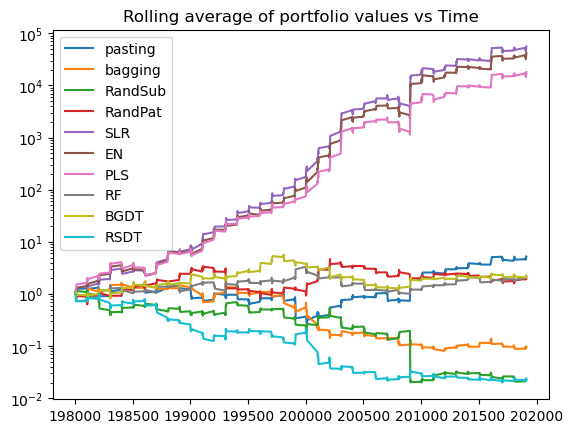

In [40]:
# plotting the results
plt.plot(pasting_ls_df.index, pasting_ls_df['cumulative_ret'], label = 'pasting')
plt.plot(bagging_ls_df.index, bagging_ls_df['cumulative_ret'], label = 'bagging')
plt.plot(RandSub_ls_df.index, RandSub_ls_df['cumulative_ret'], label = 'RandSub')
plt.plot(RandPat_ls_df.index, RandPat_ls_df['cumulative_ret'], label = 'RandPat')
plt.plot(pasting_ls_df.index, assignment7_values['slr_cum_ret'], label = 'SLR')
plt.plot(pasting_ls_df.index, assignment7_values['en_cum_ret'], label = 'EN')
plt.plot(pasting_ls_df.index, assignment7_values['pls_cum_ret'], label = 'PLS')
plt.plot(pasting_ls_df.index, assignment7_values['RF_cum_ret'], label = 'RF')
plt.plot(pasting_ls_df.index, assignment7_values['BGDT_cum_ret'], label = 'BGDT')
plt.plot(pasting_ls_df.index, assignment7_values['RSDT_cum_ret'], label = 'RSDT')

plt.yscale('log')
plt.legend()
plt.title("Rolling average of portfolio values vs Time")
    
plt.show()

In [41]:
# The r2 scores are attained if you ran the validation_model function
# I've just assigned them here since I'm not running the full function which takes time

pasting_best_r2 = 0.36701014814926813
bagging_best_r2 = 0.298693441995755
RandSub_best_r2 = 0.22127375059974574
RandPat_best_r2 = 0.3132940862694076

In [42]:
from tabulate import tabulate

table = [['Type', 'Avg Ret', 'Std. Dev', 'SR', 'R^2'],
         [assignment7_metrics['Type'][3], assignment7_metrics['Avg Ret'][3], assignment7_metrics['Std. Dev'][3],\
          assignment7_metrics['SR'][3], assignment7_metrics['R^2'][3]],
        [assignment7_metrics['Type'][4], assignment7_metrics['Avg Ret'][4], assignment7_metrics['Std. Dev'][4],\
          assignment7_metrics['SR'][4], assignment7_metrics['R^2'][4]],
        [assignment7_metrics['Type'][5], assignment7_metrics['Avg Ret'][5], assignment7_metrics['Std. Dev'][5],\
          assignment7_metrics['SR'][5], assignment7_metrics['R^2'][5]],\
         [assignment7_metrics['Type'][0], assignment7_metrics['Avg Ret'][0], assignment7_metrics['Std. Dev'][0],\
          assignment7_metrics['SR'][0], assignment7_metrics['R^2'][0]],
        [assignment7_metrics['Type'][1], assignment7_metrics['Avg Ret'][1], assignment7_metrics['Std. Dev'][1],\
          assignment7_metrics['SR'][1], assignment7_metrics['R^2'][1]],
        [assignment7_metrics['Type'][2], assignment7_metrics['Avg Ret'][2], assignment7_metrics['Std. Dev'][2],\
          assignment7_metrics['SR'][2], assignment7_metrics['R^2'][2]],\
         ['Pasting', pasting_ls_sub_rf_mean, pasting_ls_sub_rf_std, pasting_sharpe_ratio, pasting_best_r2],
         ['Bagging', bagging_ls_sub_rf_mean, bagging_ls_sub_rf_std, bagging_sharpe_ratio, bagging_best_r2],
         ['RandSub', RandSub_ls_sub_rf_mean, RandSub_ls_sub_rf_std, RandSub_sharpe_ratio, RandSub_best_r2],
         ['RandPat', RandPat_ls_sub_rf_mean, RandPat_ls_sub_rf_std, RandPat_sharpe_ratio, RandPat_best_r2]]

print(tabulate(table, headers='firstrow'))

Type         Avg Ret    Std. Dev          SR         R^2
-------  -----------  ----------  ----------  ----------
RF       -0.00425158    0.196793  -0.0748396  0.402336
BGDT     -0.00587909    0.174121  -0.116963   0.38204
RSDT     -0.110807      0.220856  -1.738      0.202954
SLR       0.271556      0.28493    3.30151    0.00460928
EN        0.266641      0.297459   3.10521    0.00483712
PLS       0.244333      0.290277   2.91582    0.00470622
Pasting   0.0286377     0.240182   0.413037   0.36701
Bagging  -0.0761057     0.217065  -1.21455    0.298693
RandSub  -0.0916185     0.241347  -1.31502    0.221274
RandPat   0.00097392    0.21221    0.0158982  0.313294
